In [72]:
import numexpr as ne
import numpy as np
import tomocam
import tomopy
import dxchange as dx
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import h5py
import os

In [73]:
def dXAtts(datafile, beamline='aps'):
    attrs = dict()
    fp = h5py.File(datafile, 'r')
    if beamline == 'als':
        gdata = dict(dx.reader._find_dataset_group(fp).attrs)
        attrs['pxsize']           = float(gdata['pxsize']) / 10  # /10 to convert units from mm to cm
        attrs['nslices']          = int(gdata['nslices'])
        attrs['nangles']          = int(gdata['nangles'])
        attrs['arange']           = float(gdata['arange'])
        attrs['nrays']            = int(gdata['nrays'])
        attrs['i0cycle']          = int(gdata['i0cycle'])
        attrs['num_dark_fields']  = int(gdata['num_dark_fields'])
        attrs['ind_dark']         = list(range(0, attrs['num_dark_fields']))
        attrs['num_bright_filed'] = int(gdata['num_bright_field'])
        attrs['rot_angle']        = float(gdata['rot_angle'])
    elif beamline == 'aps_32id':
        nangles, nslices, nrays = fp['exchange']['data'].shape
        attrs['nslices'] = nslices
        attrs['nangles'] = nangles
        attrs['nrays'] = nrays
    return attrs

# Input

In [74]:
filename = 'tomo_00001.h5'
inputPath = '/global/u2/d/dkumar/als/tomocam/data/tomo_00001/'
cor = 1024
inputFile = os.path.join(inputPath, filename)
gdata = dXAtts(inputFile, beamline='aps_32id')

In [75]:
help(dx.read_aps_32id)

Help on function read_aps_32id in module dxchange.exchange:

read_aps_32id(fname, exchange_rank=0, proj=None, sino=None, dtype=None)
    Read APS 32-ID standard data format.
    
    Parameters
    ----------
    fname : str
        Path to hdf5 file.
    
    exchange_rank : int, optional
        exchange_rank is added to "exchange" to point tomopy to the data
        to reconstruct. if rank is not set then the data are raw from the
        detector and are located under exchange = "exchange/...", to process
        data that are the result of some intemedite processing step then
        exchange_rank = 1, 2, ... will direct tomopy to process
        "exchange1/...",
    
    proj : {sequence, int}, optional
        Specify projections to read. (start, end, step)
    
    sino : {sequence, int}, optional
        Specify sinograms to read. (start, end, step)
    
    dtype : numpy datatype, optional
        Convert data to this datatype on read if specified.
    
    Returns
    ------

# Output 

In [76]:
outputPath = '/global/u2/d/dkumar/als/tomocam/recon'
if not os.path.isdir(outputPath):
    os.makedirs(outputPath)
outputFile = os.path.join(outputPath, filename)

# Load data

In [77]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sinoUsed = (gdata['nslices']//2, gdata['nslices']//2 + 8, 1)
print(sinoUsed)
proj, flat, dark, theta = dx.read_aps_32id(inputFile, sino=sinoUsed)
proj = proj.astype(np.float32)
theta = theta.astype(np.float32)

(896, 904, 1)


## Normalize and minus-log

In [78]:
proj = tomopy.normalize(proj, flat, dark, out=proj)
minimum_transmission = 0.01
mx = np.float32(minimum_transmission)
ne.evaluate('where(proj>mx, proj, mx)', out=proj)
proj = tomopy.minus_log(proj)

# Remove stripes

In [79]:
proj = tomopy.prep.stripe.remove_stripe_fw(proj, level = 7, sigma = 3)

In [80]:
sino = np.transpose(proj, [1, 0, 2]).astype(np.float32)

# Reconstruct object using MBIR

In [82]:
s = 0.0085   
max_iters = 300
recon = tomocam.MBIR(sino, theta, center = cor, num_iters = max_iters, smoothness = s)

Iteration:   0 , Error:  1397.6158447265625
Iteration:   1 , Error:  958.06298828125
Iteration:   2 , Error:  783.42431640625
Iteration:   3 , Error:  602.5482788085938
Iteration:   4 , Error:  431.3506774902344
Iteration:   5 , Error:  287.5815734863281
Iteration:   6 , Error:  183.170166015625
Iteration:   7 , Error:  126.63475036621094
Iteration:   8 , Error:  110.47601318359375
Iteration:   9 , Error:  108.13444519042969
Iteration:   10 , Error:  100.89431762695312
Iteration:   11 , Error:  85.16021728515625
Iteration:   12 , Error:  63.97349548339844
Iteration:   13 , Error:  41.5567741394043
Iteration:   14 , Error:  23.114015579223633
Iteration:   15 , Error:  16.74668312072754
Iteration:   16 , Error:  22.065568923950195
Iteration:   17 , Error:  27.29847526550293
Iteration:   18 , Error:  29.157817840576172
Iteration:   19 , Error:  27.966463088989258
Iteration:   20 , Error:  24.79340171813965
Iteration:   21 , Error:  20.75864028930664
Iteration:   22 , Error:  16.7684860229

# Mask each reconstructed slice with a circle.

In [83]:
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95)

# Show results

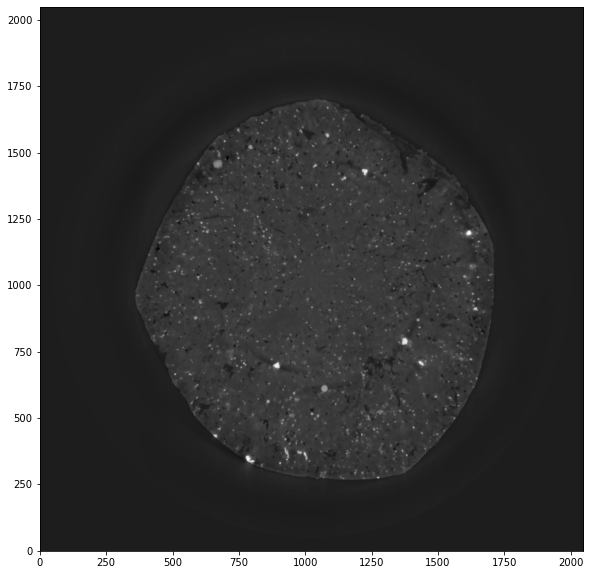

In [84]:
plt.imshow(recon[0], origin='lower', cmap='gray')

# Save to hdf5

In [85]:
with h5py.File(outputFile, 'w') as fp:
    dset = fp.create_dataset('recon', data = recon)
    dset.attrs['smoothness'] = s
    dset.attrs['num_iters'] = max_iters
    dset.attrs['remove_stripe_fw'] = 'level : 7, sigma: 3'
    dset.attrs['minimum_transmission'] = minimum_transmission